In [11]:
import torch
import torch_geometric


import math
from typing import Optional

import torch
from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn.aggr import Aggregation
from torch_geometric.utils import softmax
import torch_geometric.transforms as T
from sklearn.utils import murmurhash3_32

import numpy as np

import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing, Sequential
from torch_geometric.utils import add_self_loops, degree

from typing import Union

from torch_sparse import SparseStorage, SparseTensor

from sys import maxsize


In [2]:
class MinHashAggregation(Aggregation):
    r"""An aggregation operator that sums up features across a set of elements

    .. math::
        \mathrm{sum}(\mathcal{X}) = \sum_{\mathbf{x}_i \in \mathcal{X}}
        \mathbf{x}_i.
    """
    def __init__(self, d=1000, seed=1):
        super().__init__()
        assert type(d) is int
        assert type(seed) is int or type(seed) is list
        
        self.d = d
        self.seed = seed
    
    def forward(self, x: Tensor, index: Optional[Tensor] = None,
                ptr: Optional[Tensor] = None, dim_size: Optional[int] = None,
                dim: int = -2) -> Tensor:
        
        if type(self.seed) is int:
            hashes = (murmurhash3_32(np.array(x, dtype=np.int32), positive=True, seed=self.seed) % self.d).astype(np.int32)
            hashes = torch.tensor(hashes)
        # else:
        #     hashes = None
        #     for cur_seed in self.seed:
        #         cur_hash = (murmurhash3_32(np.array(x, dtype=np.int32), positive=True, seed=cur_seed) % self.d).astype(np.int32)
        #         if hashes is not None:
        #             hashes = np.hstack((hashes, cur_hash))
        #         else:
        #             hashes = cur_hash
            
        #     hashes = torch.tensor(hashes)
        #     print(hashes.shape)
        
        return self.reduce(hashes, index, ptr, dim_size, dim, reduce='min')


class MinHashConv(MessagePassing):
    def __init__(self, d=1000, seed=1):
        self.d = d
        self.seed = seed
        # super().__init__(aggr='min')
        super().__init__(aggr=MinHashAggregation(d=self.d, seed=self.seed))
        
        self.reset_parameters()

    def reset_parameters(self):
        pass

    def forward(self, x, edge_index):
        out = self.propagate(edge_index, x=x, j=edge_index[0])
        return out

    def message(self, x_j, j):
        # print(j, x_j)
        # hashes = (murmurhash3_32(np.array(j, dtype=np.int32), positive=True, seed=self.seed) % self.d).astype(np.int32)
        # hashes = torch.tensor(hashes)
        # print(hashes.shape)
        # return hashes[:, None]
        # print(j)
        return x_j
    

def edge_cut(clusters, edges):
    # num_clusters = clusters.unique()
    # intra_cluster_edges = clusters[edges[0]] == clusters[edges[1]]
    # for cluster in range(num_clusters):
    #     intra_cluster_edges == cluster
    return torch.sum(clusters[edges[0]] != clusters[edges[1]]) / edges.shape[-1]

In [24]:
from utils import load_dataset

data, pyg_data = load_dataset("Cora")

transform = T.Compose([T.ToUndirected(), T.LargestConnectedComponents()])
data = transform(data)

model = Sequential('x, edge_index', [
    (MinHashConv(d=maxsize, seed=61), 'x, edge_index -> x1'),
    (MinHashConv(d=maxsize, seed=62), 'x1, edge_index -> x2'),
    (MinHashConv(d=maxsize, seed=63), 'x2, edge_index -> x3'),
    (MinHashConv(d=maxsize, seed=64), 'x3, edge_index -> x4'),
    (MinHashConv(d=maxsize, seed=65), 'x4, edge_index -> x5'),
    # (MinHashConv(d=2**18, seed=[16, 26, 36, 46, 56, 66]), 'x5, edge_index -> x6'),
    # (MinHashConv(d=2**18, seed=[17, 27, 37, 47, 57, 67]), 'x6, edge_index -> x7'),
])

In [25]:
import networkx as nx
test_nx = torch_geometric.utils.to_networkx(data)
nx.is_connected(test_nx.to_undirected())

True

In [26]:
data.edge_index[:, :10]

tensor([[   0,    0,    0,    1,    1,    1,    2,    2,    2,    2],
        [ 575, 1722, 2400,    2,  592,  593,    1,  296, 1334, 1531]])

In [5]:
x = torch.tensor(np.arange(0, data.num_nodes, dtype=np.int32)[:, None])

In [9]:
data.edge_index[:, :20]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [  4,   6,   7,  10,  12,  18,  25,  27,  29,  39,  45,  56,  60,  64,
          79, 113, 121, 127, 142, 146]])

In [20]:
min_hash_conv = MinHashConv(d=maxsize, seed=61)

In [26]:
murmurhash3_32(np.array(x, dtype=np.int32), positive=True, seed=self.seed) % self.d).astype(np.int32)

tensor([[4039, 2424, 4039,  ...,  338,  835, 3554],
        [2424, 4039,  225,  ...,  708, 3554,  835]])

In [21]:
min_hash_conv(x, data.edge_index)

tensor([[-2137695568],
        [-2147109059],
        [-2147109059],
        ...,
        [-2043130678],
        [-2116198552],
        [-1369441213]], dtype=torch.int32)

In [32]:
# %%timeit
x = torch.tensor(np.arange(0, data.num_nodes, dtype=np.int32)[:, None])
out = model(x, data.edge_index)
out.unique()

tensor([-1564756564, -1542140473, -1203341618,  -724279553,    15241604,
          770556394,  1692446320,  1714295174], dtype=torch.int32)

Text(0.5, 0, 'Cluster')

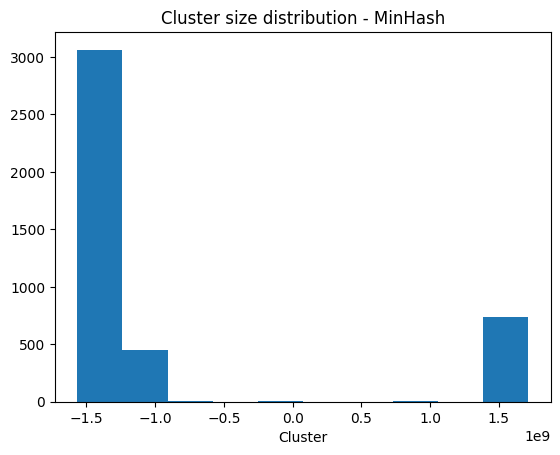

In [16]:
import matplotlib.pyplot as plt

plt.hist(out.numpy())
plt.title("Cluster size distribution - MinHash")
plt.xlabel("Cluster")

In [17]:
cluster_stats = {}
for cur_cluster in out.unique():
    cluster_stats[cur_cluster.item()] = np.histogram(data.y[out.squeeze(1) == cur_cluster].numpy(), bins=[0, 1, 2, 3, 4, 5, 6, 7])[0]
    
    
# Example usage:
data = list(cluster_stats.values())
categories = list(range(len(data[0])))

labels = list(range(len(data)))
title = 'Classes per cluster - MinHash'
xlabel = 'Clusters'
ylabel = 'Values'

stacked_bar_chart(categories, data, labels, title, xlabel, ylabel)

TypeError: 'NoneType' object is not subscriptable

## Checking connectivity

In [13]:
import networkx as nx
test_nx = torch_geometric.utils.to_networkx(data)
nx.is_connected(test_nx.to_undirected())

True

In [33]:
import networkx as nx

for cur_cluster in out.unique():
    test = data.subgraph(out.squeeze(1) == cur_cluster)
    test_nx = torch_geometric.utils.to_networkx(test)
    print(cur_cluster, nx.is_connected(test_nx.to_undirected()))

tensor(-1564756564, dtype=torch.int32) True
tensor(-1542140473, dtype=torch.int32) False
tensor(-1203341618, dtype=torch.int32) False
tensor(-724279553, dtype=torch.int32) False
tensor(15241604, dtype=torch.int32) False
tensor(770556394, dtype=torch.int32) False
tensor(1692446320, dtype=torch.int32) False
tensor(1714295174, dtype=torch.int32) False


In [278]:
edge_cut(out, data.edge_index)

tensor(0.4991)

In [9]:
class MinHashConv_2(MessagePassing):
    def __init__(self, d=int, seed=Union[list, int]):
        '''
        This is just a simple layer used to run message passing
        using the MinHashAggregation.
        '''
        self.d = d
        self.seed = seed
        super().__init__(aggr='min')
        
        self.reset_parameters()

    def reset_parameters(self):
        pass

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        out = self.propagate(edge_index, x=x)
        
        # When we have more than a single hash [h1, h2, h3]
        # reduce only computes min(h1), min(h2), min(h3).
        # So to get min(min(h1), min(h2), min(h3)) we need this 
        # additional step
        out = out.min(dim=1)[0][:, None]
        return out

    def message(self, x_j):
        
        if type(self.seed) is int:
            hashes = (murmurhash3_32(np.array(x_j, dtype=np.int32), positive=True, seed=self.seed) % self.d).astype(np.int32)
            hashes = torch.tensor(hashes)
        else:
            hashes = None
            for cur_seed in self.seed:
                cur_hash = (murmurhash3_32(np.array(x_j, dtype=np.int32), positive=True, seed=cur_seed) % self.d).astype(np.int32)
                if hashes is not None:
                    hashes = np.hstack((hashes, cur_hash))
                else:
                    hashes = cur_hash
            hashes = torch.tensor(hashes)
            
        return hashes
    

In [10]:
from utils import load_dataset

data, pyg_data = load_dataset("Cora")

model = Sequential('x, edge_index', [
    (MinHashConv_2(d=2**18, seed=[11, 21, 31, 41, 51, 61]), 'x, edge_index -> x1'),
    (MinHashConv_2(d=2**18, seed=[12, 22, 32, 42, 52, 62]), 'x1, edge_index -> x2'),
    (MinHashConv_2(d=2**18, seed=[13, 23, 33, 43, 53, 63]), 'x2, edge_index -> x3'),
    (MinHashConv_2(d=2**18, seed=[14, 24, 34, 44, 54, 64]), 'x3, edge_index -> x4'),
    (MinHashConv_2(d=2**18, seed=[15, 25, 35, 45, 55, 65]), 'x4, edge_index -> x5'),
    (MinHashConv_2(d=2**18, seed=[16, 26, 36, 46, 56, 66]), 'x5, edge_index -> x6'),
    (MinHashConv_2(d=2**18, seed=[17, 27, 37, 47, 57, 67]), 'x6, edge_index -> x7'),
])

/home/jrm28/.conda/envs/gelato_clone/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:183: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [16]:
%%timeit
x = torch.tensor(np.arange(0, data.x.shape[0], dtype=np.int32)[:, None])
out = model(x, data.edge_index)
out.unique()

torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size([13264, 6])
torch.Size(

## METIS

In [37]:
data, pyg = load_dataset('Cora')

data.edge_attr = torch.ones([data.edge_index.shape[1], 1], dtype=int)

A = SparseTensor.from_edge_index(data.edge_index, edge_attr=torch.ones(size=(data.edge_index.shape[1],)))

/home/jrm28/.conda/envs/gelato_clone/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:183: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [48]:
partitions, part_idx, part_nodes = A.partition(10)

clusters = torch.zeros_like(part_nodes)

for idx, (part_start, part_end) in enumerate(list(zip(part_idx, part_idx[1:]))):
    clusters_idx = part_nodes[part_start: part_end]
    clusters[clusters_idx] = idx

Text(0.5, 0, 'Cluster')

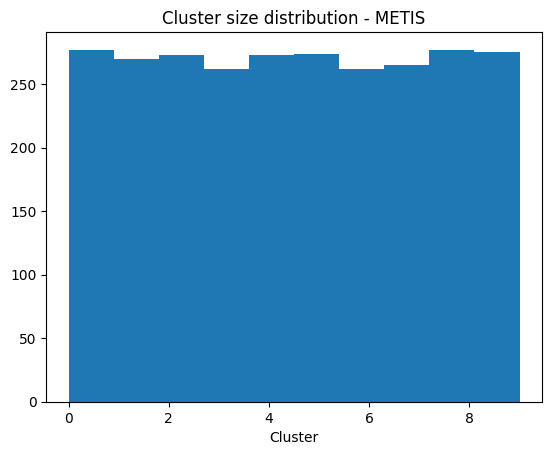

In [51]:
plt.hist(clusters.numpy())
plt.title("Cluster size distribution - METIS")
plt.xlabel("Cluster")

In [ ]:
np.histogram

In [59]:
np.histogram(data.y[clusters == cur_cluster].numpy(), bins=[0, 1, 2, 3, 4, 5, 6])

(array([ 12,  10,   3, 189,  61,   0]), array([0, 1, 2, 3, 4, 5, 6]))

In [64]:
cluster_stats = {}
for cur_cluster in clusters.unique():
    cluster_stats[cur_cluster.item()] = np.histogram(data.y[clusters == cur_cluster].numpy(), bins=[0, 1, 2, 3, 4, 5, 6])[0]

In [65]:
cluster_stats

{0: array([ 17, 168,   4,  28,  56,   4]),
 1: array([  0,   0,   9,  25,  78, 158]),
 2: array([186,   7,   2,  55,  14,   9]),
 3: array([71,  0,  8, 52, 40, 91]),
 4: array([ 44,   8,   3,  62,   4, 152]),
 5: array([  1,   7, 260,   1,   1,   4]),
 6: array([  5,  13, 120,  80,  27,  17]),
 7: array([  7,   0,   4,  70, 141,  43]),
 8: array([  8,   4,   5, 256,   4,   0]),
 9: array([ 12,  10,   3, 189,  61,   0])}

/tmp/ipykernel_2685274/1895627454.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20c', num_series)


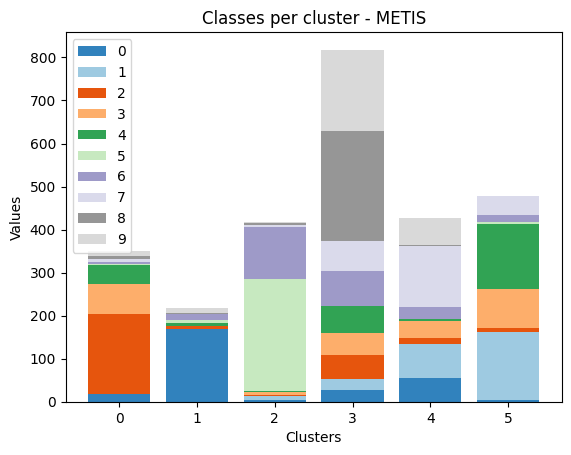

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def stacked_bar_chart(categories, data, labels, title, xlabel, ylabel):
    """
    Generate a stacked bar chart.

    Parameters:
        categories (list of str): Categories for the bars.
        data (list of lists): Data for the stacked bars. Each inner list represents the
            values for a category.
        labels (list of str): Labels for the data series.
        title (str): Title of the chart.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    num_categories = len(categories)
    num_series = len(data)

    # Create a list of bottom values for the bars to be stacked on
    bottom_values = [0] * num_categories

    # Create a color map for the data series
    colors = plt.cm.get_cmap('tab20c', num_series)

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Plot each data series as a stacked bar
    for i in range(num_series):
        ax.bar(categories, data[i], label=labels[i], bottom=bottom_values, color=colors(i))
        bottom_values = np.add(bottom_values, data[i])

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Add legend
    ax.legend()

    # Show the chart
    plt.show()

# Example usage:
data = list(cluster_stats.values())
categories = list(range(len(data[0])))

labels = list(range(len(data)))
title = 'Classes per cluster - METIS'
xlabel = 'Clusters'
ylabel = 'Values'

stacked_bar_chart(categories, data, labels, title, xlabel, ylabel)

In [67]:
len(data)

10